Import Relevant Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


Inspect Data

In [3]:
resale_approval_full = pd.read_csv("data/fixed_resale_with_bus.csv", index_col=0)

Our raw dataset looks as such:

In [4]:
resale_approval_full.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops
index,,,,,,,,,,,
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,0.0
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,0.0
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,0.0
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,0.0
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,1.0


A look at summary statistics for resale by registration and approval

In [5]:
resale_approval_full.describe()

,floor_area_sqm,lease_commence_date,resale_price,busstops
count,656851.000000,656851.000000,656851.000000,656851.000000
mean,95.171843,1985.895573,254281.174816,2.483970
std,26.432940,8.285107,123254.959795,1.540395
min,28.000000,1966.000000,5000.000000,0.000000
25%,70.000000,1980.000000,163000.000000,2.000000
50%,92.000000,1985.000000,239000.000000,2.000000
75%,115.000000,1992.000000,330000.000000,4.000000
max,307.000000,2012.000000,903000.000000,10.000000


### Data Processing

In [6]:
resale_approval_full.count()

month                  656851
town                   656851
flat_type              656851
block                  656851
street_name            656851
storey_range           656851
floor_area_sqm         656851
flat_model             656851
lease_commence_date    656851
resale_price           656851
busstops               656851
dtype: int64

In [7]:
## A function that would be flexible enough to transform categorical datasets.
## Note: Some preprocessing probably needs to be done, to convert some string variables to float
from housing.preprocess import *

**DEPRECIATED**: Preprocessing resale_registration_full

In [1]:
## DEPRECIATED
'''
From above, we can see that some fields are not clean. For example, in `resale_registration_full.remaining_lease`, `NaN` values are present. These `NaN` appear as a result of the lack of data in part of the dataset

- We choose to convert these values to 0. If lease is unknown, we should treat it asif they aren't present. Furthermore, the dataset is of a older timeframe and as such, treating it as relatively lower than the rest is acceptable
'''
## Analysis using resale_registration_full
## 1. Process data
resale_registration_full = pd.read_csv("data/resale-flat-prices_HDB/resale-on-registration-full.csv", index_col=0)

## convert NaN values to 0
resale_registration_full = resale_registration_full.fillna(0)

def convert_remaining_lease(s):
    if s == 0:
        return 0
    elif type(s) == float:
        return s
    elif type(s) == str:
        list_s = s.split(' ')
        if len(list_s) == 2:  ## X years
            return int(list_s[0])
        elif len(list_s) == 4:  ## X years Y months
            return(int(list_s[0]) + float(list_s[2]))
        elif len(list_s) == 1:  ## 78
            return(float(s))
    elif type(s == int):
        return float(s)
    raise Exception(f"Weird remaining_lease format: {s}, type: {type(s)}")
            
def to_lower_alpha(s:str):
    return(s.lower())

def months_since2012(s:str):
    ## months are in this format: YYYY-MM
    YYMM =s.split('-')
    return (12 * (int(YYMM[0]) - 2012) + (int(YYMM[1]))) 
        
resale_registration_full['flat_model'] = resale_registration_full['flat_model'].apply(to_lower_alpha)
resale_registration_full['remaining_lease'] = resale_registration_full['remaining_lease'].apply(convert_remaining_lease)
resale_registration_full['month'] = resale_registration_full['month'].apply(months_since2012)

lb_cols = ["flat_model", "flat_type", "town", "street_name"]
le_cols = ["storey_range"]
resale_registration_full = process_data(resale_registration_full, lb_cols, le_cols)

assert resale_registration_full.shape == (157517, 606)

# resale_registration_fullX = resale_registration_full.reset_index(drop=True)
X = resale_registration_full.drop(['resale_price','block'], axis=1)
y = resale_registration_full['resale_price']

NameError: name 'pd' is not defined

Preprocessing data on resale_approval_full

In [8]:
def commence_date_to_remaining(year: int):
    import datetime
    return 99 - (datetime.datetime.now().year - year)

def months_since1990(s:str):
    ## months are in this format: YYYY-MM
    YYMM =s.split('-')
    return (12 * (int(YYMM[0]) - 1990) + (int(YYMM[1]))) 

## using process_data() on resale_approval_full
resale_approval_full = pd.read_csv("data/fixed_resale_with_bus.csv", index_col=0)
resale_approval_full['month_index_since_1990'] = resale_approval_full['month'].apply(months_since1990)
resale_approval_full['flat_type'] = resale_approval_full['flat_type'].apply(lambda x: x.lower())
resale_approval_full['lease_remaining'] = resale_approval_full['lease_commence_date'].apply(commence_date_to_remaining)
# resale_approval_full = resale_approval_full.drop(["block", "lease_commence_date"], axis=1)

In [9]:
resale_approval_full.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops,month_index_since_1990,lease_remaining
index,,,,,,,,,,,,,
656846,2012-02,YISHUN,5 room,212,YISHUN ST 21,10 TO 12,121.0,Improved,1985,476888.0,2.0,266,64
656847,2012-02,YISHUN,5 room,758,YISHUN ST 72,01 TO 03,122.0,Improved,1986,490000.0,3.0,266,65
656848,2012-02,YISHUN,5 room,873,YISHUN ST 81,01 TO 03,122.0,Improved,1988,488000.0,1.0,266,67
656849,2012-02,YISHUN,executive,664,YISHUN AVE 4,07 TO 09,181.0,Apartment,1992,705000.0,3.0,266,71
656850,2012-02,YISHUN,executive,293,YISHUN ST 22,04 TO 06,163.0,Apartment,1992,630000.0,2.0,266,71


In [10]:
unique_flats = resale_approval_full[["block", "street_name", "storey_range"]].drop_duplicates()
unique_flats.shape

(38578, 3)

### Getting variables that follow a time series

As explained in the report, we aren't using time-series models to fit the data and yet we need time-series dependent variables such as:
- last known resale price 
- time since the last resale price

We get a subset of each unique block in the dataset, lag it and concatnate the final datasets 

In [11]:
## lag_housing_df takes resale_approval_full above and does the above step
# lag_housing_df(resale_approval_full) 

In [12]:
## data was written to csv previously so we just load from it
lagged_data = pd.read_csv("data/lagged_approval.csv", index_col=0)
print(lagged_data.shape)
lagged_data.head()

(618273, 15)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,busstops,month_index_since_1990,lease_remaining,last_known_price,months_since_last
0,1990-01,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,0.0,1,56,9000.0,0.0
1,1990-05,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,7800.0,0.0,5,56,8000.0,4.0
2,1990-08,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,0.0,8,56,7800.0,3.0
3,1990-09,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9500.0,0.0,9,56,9500.0,1.0
4,1990-10,ANG MO KIO,1 room,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,5800.0,0.0,10,56,9500.0,1.0


Next code block adds **GDP** for the year which the resale occued

In [13]:
gdp_data = get_processed_gdp_data()
gdp_data[gdp_data["year"] >= 1990].head()

,year,GDP_value,GDP_perc_change
30,1990,70492.3,14.979652
31,1991,78542.8,11.420396
32,1992,84920.2,8.119649
33,1993,97923.1,15.311905
34,1994,112555.4,14.942644


In [18]:
lagged_data["year"] = lagged_data["month"].apply(lambda x: int(x[:x.rfind('-')]))
lagged_data = lagged_data.merge(gdp_data, on=["year"])

In [19]:
full_df_subset = lagged_data.copy(deep=True)
# full_df_subset["flat"] = full_df_subset["block"] + " " + full_df_subset["street_name"]
# full_df_subset.drop(["block", "street_name", "month"], axis=1, inplace=True)
full_df_subset.drop(["block", "month", "lease_commence_date"], axis=1, inplace=True)

In [20]:
full_df_subset.head()

,town,flat_type,street_name,storey_range,floor_area_sqm,flat_model,resale_price,busstops,month_index_since_1990,lease_remaining,last_known_price,months_since_last,year,GDP_value,GDP_perc_change
0,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,8000.0,0.0,1,56,9000.0,0.0,1990,70492.3,14.979652
1,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,7800.0,0.0,5,56,8000.0,4.0,1990,70492.3,14.979652
2,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,9500.0,0.0,8,56,7800.0,3.0,1990,70492.3,14.979652
3,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,9500.0,0.0,9,56,9500.0,1.0,1990,70492.3,14.979652
4,ANG MO KIO,1 room,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,5800.0,0.0,10,56,9500.0,1.0,1990,70492.3,14.979652


In [21]:
full_df_corr = full_df_subset.corr()
full_df_corr

,floor_area_sqm,resale_price,busstops,month_index_since_1990,lease_remaining,last_known_price,months_since_last,year,GDP_value,GDP_perc_change
floor_area_sqm,1.000000,0.745815,0.101062,0.093425,0.551791,0.657572,0.143490,0.093285,0.080457,-0.047746
resale_price,0.745815,1.000000,0.054439,0.439077,0.478934,0.867022,0.192576,0.438026,0.473119,-0.056071
busstops,0.101062,0.054439,1.000000,0.067992,0.209832,0.058716,-0.008264,0.067823,0.056493,-0.017398
month_index_since_1990,0.093425,0.439077,0.067992,1.000000,0.311443,0.397299,0.224866,0.998638,0.956445,0.011383
lease_remaining,0.551791,0.478934,0.209832,0.311443,1.000000,0.484222,0.035050,0.310774,0.284459,-0.035339
last_known_price,0.657572,0.867022,0.058716,0.397299,0.484222,1.000000,0.085724,0.396745,0.399043,-0.127325
months_since_last,0.143490,0.192576,-0.008264,0.224866,0.035050,0.085724,1.000000,0.224665,0.235131,0.075509
year,0.093285,0.438026,0.067823,0.998638,0.310774,0.396745,0.224665,1.000000,0.957843,0.011541
GDP_value,0.080457,0.473119,0.056493,0.956445,0.284459,0.399043,0.235131,0.957843,1.000000,0.138826
GDP_perc_change,-0.047746,-0.056071,-0.017398,0.011383,-0.035339,-0.127325,0.075509,0.011541,0.138826,1.000000


Inspecting for multicollinearity:

Plot correlation matrix for predictors only to look for strong/perfect correlation
between variables and delete if necessary

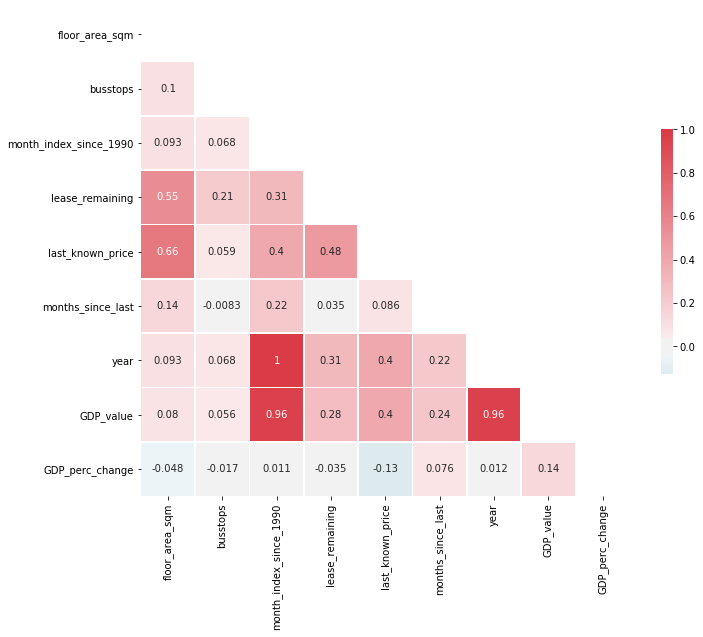

In [30]:
X_corr = full_df_subset.drop("resale_price", axis=1).corr()
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(X_corr, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(X_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

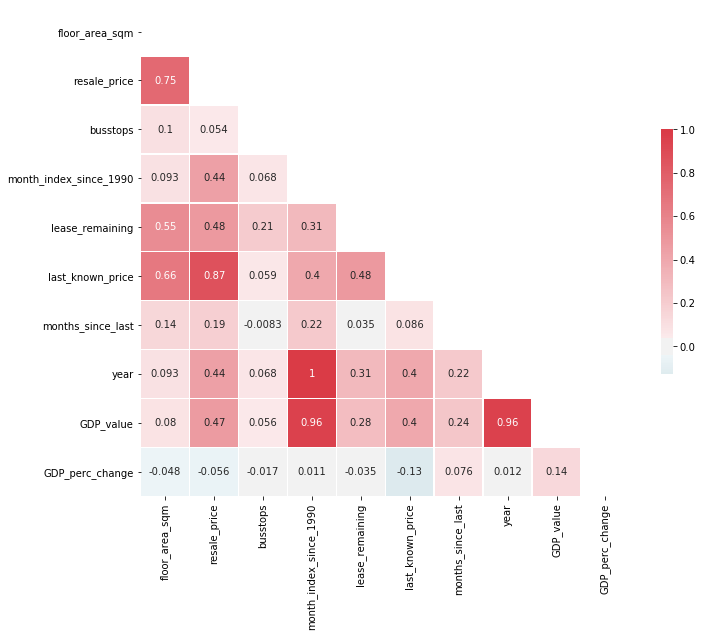

In [31]:
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(full_df_corr, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(full_df_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

While `busstops` are uncorrelated with `resale_price` , we can do it after looking at the significance of busstops in predicting `resale_price`

In [37]:
'''
Instead of putting the past price as a predictor, we let the predictor be a differential of the previous known price, similar to getting differentials in ARIMA models. 

We compare this method against the former method, to see which method is better in prediction with a possible explanation
'''
differential_df = full_df_subset.copy(deep=True)
differential_df["price_difference"] = differential_df["resale_price"] - differential_df["last_known_price"]
differential_df.drop(["resale_price", "last_known_price"], axis=1, inplace=True)

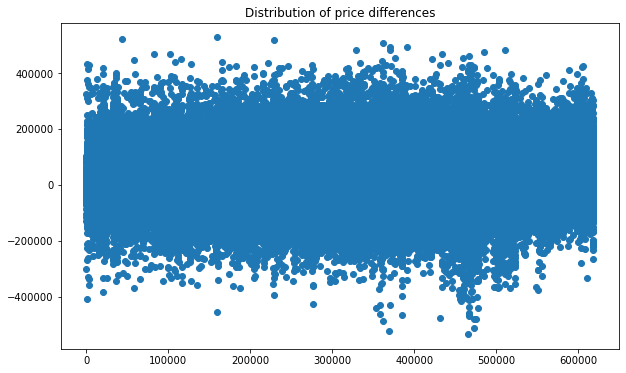

In [38]:
plt.figure(figsize=(10,6))
plt.title("Distribution of price differences")
plt.scatter(differential_df.index, differential_df["price_difference"])

It seems to be stationary with mean at around 0. A linear model definitely wont fit this will not use price differences as the predicted variable.

In [39]:
'''diff_df_corr = differential_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(diff_df_corr, dtype=np.bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(diff_df_corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)'''

'diff_df_corr = differential_df.corr()\nf, ax = plt.subplots(figsize=(11, 9))\nmask = np.triu(np.ones_like(diff_df_corr, dtype=np.bool))\n# Generate a custom diverging colormap\ncmap = sns.diverging_palette(220, 10, as_cmap=True)\nsns.heatmap(diff_df_corr, mask=mask, cmap=cmap, vmax=1, center=0,\n            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)'

### Model fitting - ML Techniques

In [ ]:
'''
process data to fit model fitting techniques
'''
# lb_cols = ["flat_model", "flat", "town"]
lb_cols = ["flat_model", "street_name", "town"]
le_cols = ["flat_type", "storey_range"]
approval = process_data(full_df_subset, lb_cols= lb_cols, le_cols=le_cols)
print(approval.shape)

X_approval = approval.drop("resale_price", axis=1)
y_approval = approval["resale_price"]

In [ ]:
## functions to fit ML_models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## code is in housing/ML.py
from housing.ML import ML_Model

def split_df(X, y):
    return train_test_split(X, y, test_size=0.25)

In [ ]:
## ML techniques - Lasso
lasso = Lasso()
lasso_model = ML_Model(lasso, X_approval, y_approval, split_df)
lasso_model.fit()
lasso_model.predict()
lasso_model.get_metrics()
# lasso.fit(X_train,y_train)
# print(lasso.score(X_train, y_train))

In [ ]:
## ML techniques - Bayesian Ridge
br = BayesianRidge()
br_model = ML_Model(br, X_approval, y_approval, split_df)
br_model.fit()
br_model.predict()
br_model.get_metrics()

Compare Against Differentials

In [ ]:
# diff_approval = process_data(differential_df, lb_cols= lb_cols, le_cols=le_cols)
# X_diff_approval = diff_approval.drop("price_difference", axis=1)
# y_diff_approval = diff_approval["price_difference"]
# print(differential_df.columns)

## ML techniques - Bayesian Ridge
br = BayesianRidge()
br_model = ML_Model(br, X_diff_approval, y_diff_approval, split_df)
br_model.fit()
br_model.predict()
br_model.get_metrics()

RFC - it takes really long to run this so I haven't

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_train,y_train)
print(rfr.score(X_train, y_train))

Rolling predictions

build models with data on year $n$ to predict data on year $n+1$. We concat all predicted values.

In [ ]:
lasso_model.rolling_predict(12)

In [ ]:
lasso_model.get_metrics()

In [ ]:
lasso_model.rolling_predict(6)
lasso_model.get_metrics()

It seems that rolling predictions work better. This might likely be due to structural information that 
might be lost but persisted in the future due to models taking averages over the whole time period to
minimise loss functions.

### Explained Variance
Lasso on processed resale_registration_full : 0.05792120689732261

Bayesian Ridge on processed resale_registration_full : 0.07078195564484402

Rolling predictions, Lasso on processed resale_registration_full : 0.2625062541461246

Rolling predictions,Bayesian Ridge on processed resale_registration_full : 



### Deep Learning Techniques

#### ANN

In [ ]:
X_train, X_test, y_train, y_test = split_df(X, y)
df = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).batch(16)
# for feat, targ in df.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])
model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae', 'mse'])

In [ ]:
model.summary()

In [ ]:
EPOCHS = 100

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

In [ ]:
## save model
model.save_weights("./checkpoints/ann-epoch-100")

In [ ]:
## prediction
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
print(mean_squared_error(y_pred, y_test))
print(mean_absolute_error(y_pred, y_test))
print(explained_variance_score(y_pred, y_test))

### Time-series

Using a subset of data (certain street), we try to model data as a time-series, 
hopefully it'll improve eval metrics  

**Exogeneous Variables**

These are variables that would be similar throughout the time series and values dont change with time

- storey_range
- floor_area_sqm
- flat_model
- flat_type
- lease_commence_date -> remaining_lease

**Problems:**

We need one model per flat, which takes up alot of storage space and 
having so many models might be inefficient

In [ ]:
time_series_registration = pd.read_csv("data/resale-flat-prices_HDB/resale-on-approval-full.csv")
time_series_registration.drop_duplicates(inplace=True)
time_series_registration["lease_remaining"] = time_series_registration["lease_commence_date"].apply(commence_date_to_remaining)
time_series_registration["flat_model"] = time_series_registration["flat_model"].apply(lambda x: x.lower())
time_series_registration.drop("lease_commence_date", axis=1, inplace=True)
print(time_series_registration.columns)
time_series_registration.shape

1. Lag the values

In [ ]:
time_series_registration.sort_values(by=["street_name", "block", "month", "storey_range"], inplace=True)
sorted_time_series = time_series_registration.reset_index(drop=True)
sorted_time_series["last_resale_price"] = sorted_time_series["resale_price"].shift(1)
sorted_time_series.dropna(inplace=True)
sorted_time_series

In [ ]:
sorted_time_series["month"] = sorted_time_series["month"].apply(lambda x: int(x[:4])*12 + int(x[-2:])-1)
sorted_time_series.drop(["block", "town"],axis=1, inplace=True)
lb_cols = ["street_name", "flat_type", "flat_model"]
le_cols=["storey_range"]
ts_df = process_data(sorted_time_series,lb_cols=lb_cols, le_cols=le_cols)
ts_df.head(10)

In [ ]:
# np.amax(ts_df.month) ##24145
# np.amin(ts_df.month)  ## 23880
X = ts_df.drop("resale_price", axis=1)
y = ts_df["resale_price"]
# X_train, X_test, y_train, y_test = split_df(X, y, month_threshold=24110)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [ ]:
def tf_split(X, y):
    return split_df(X,y, month_threshold=24110)

br = BayesianRidge()
br_model = ML_Model(br, X, y, tf_split)
br_model.fit()
br_model.predict()
br_model.get_metrics()

In [ ]:
br_model.rolling_predict(12)

In [ ]:
br_model.get_metrics()

### Checking Model Assumptions

In this section, we look at whether the fitted model satifies assumptions in the underlying model. 

For example, regression requires data to be homoscedastic. We observe this in a residual plot or QQ-plot, where residuals should look like a random variable with mean 0 while QQ-plot should show a straight line.